In [31]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import collections
from sklearn.preprocessing import scale

In [57]:
COLUMNS_TO_DROP = [
    'Category',
    'Item',
    'Serving Size',
    'Calories from Fat',
    'Total Fat',
    'Saturated Fat',
    'Cholesterol',
    'Sodium',
    'Carbohydrates',
    'Dietary Fiber',
]

def prepare_data():
    data = pd.read_csv('menu.csv').drop(columns=COLUMNS_TO_DROP)
    for key in data.keys():
        print(key)
        # if key == 'Calories':
        #     data[key] /= 2000
        # elif key == 'Trans Fat' or key == 'Sugars' or key == 'Protein':
            # data[key] = scale(data[key].values, axis=0, with_mean=True, with_std=True, copy=True)
        # else:
        #     data[key] /= 100
    print(data)
    # scaler = StandardScaler()
    # data = scaler.fit_transform(data)
    return data

prepared_data = prepare_data()

Calories
Total Fat (% Daily Value)
Saturated Fat (% Daily Value)
Trans Fat
Cholesterol (% Daily Value)
Sodium (% Daily Value)
Carbohydrates (% Daily Value)
Dietary Fiber (% Daily Value)
Sugars
Protein
Vitamin A (% Daily Value)
Vitamin C (% Daily Value)
Calcium (% Daily Value)
Iron (% Daily Value)
     Calories  Total Fat (% Daily Value)  Saturated Fat (% Daily Value)  \
0         300                         20                             25   
1         250                         12                             15   
2         370                         35                             42   
3         450                         43                             52   
4         400                         35                             42   
..        ...                        ...                            ...   
255       510                         26                             44   
256       690                         35                             58   
257       340              

In [38]:
def kmeans_metric(data, n_clusters, init):
    km = KMeans(n_clusters=n_clusters, init=init, n_init=10, verbose=0)
    km.fit(data)
    return metrics.davies_bouldin_score(data, km.labels_)

N_CLUSTERS = 6

def full_random(X, n_clusters, random_state):
    X = np.array(X)
    rng = np.random.default_rng()
    initialization = []
    for i in range(X.shape[1]):
        X_i = X[:,i]
        initialization.append(rng.uniform(np.min(X_i), np.max(X_i), n_clusters))
    return np.stack(initialization, axis=1)


init_methods = ['k-means++', 'random', full_random]

for init_method in init_methods:
    metric = kmeans_metric(prepared_data, N_CLUSTERS, init_method)
    print(metric)

0.93184639734287
0.929194719320776
0.7391418707731247


In [42]:
def run_one_iter_kmeans(data, init, n_clusters):
    km = KMeans(n_clusters=n_clusters, max_iter=1, n_init=1, init=init)
    km.fit(data)
    return km


def get_mean_and_stddev(results):
    means = []
    std_devs = []
    for result in results:
        means.append(np.mean(result))
        std_devs.append(np.std(result))
    return np.array(means), np.array(std_devs)


def track_method(data, method, n_clusters, n_tries, n_iters):
    metric_values = []
    for trial_no in range(n_tries):
        values = []
        km = run_one_iter_kmeans(data, method, n_clusters)
        centers = km.cluster_centers_
        for iter_no in range(n_iters):
            km = run_one_iter_kmeans(data, centers, n_clusters)
            value = metrics.davies_bouldin_score(data, km.labels_)
            values.append(value)
            centers = km.cluster_centers_
        metric_values.append(values)
    results = np.transpose(np.array(metric_values))
    return get_mean_and_stddev(results)


def plot_tracking_result(means, std_devs, x_label, y_label, filename):
    plt.bar(range(means.shape[0]), means, yerr=std_devs, align='center', alpha=0.75, ecolor='red', capsize=4)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.savefig(filename)
    plt.clf()

init_methods = ['k-means++', 'random', full_random]
for init_method in init_methods:
    means, std_devs = track_method(prepared_data, init_method, 6, 10, 40)
    print(f"method {init_method}, mean {means[-1]}, std_dev {std_devs[-1]}")
    plot_tracking_result(means, std_devs, "iteration_number", "metric value", str(init_method))

method k-means++, mean 0.9203286587315196, std_dev 0.05013903299041843
method random, mean 0.9081230541450157, std_dev 0.09722014387694257


<ipython-input-42-7f21747af7de>:3: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  km.fit(data)


method <function full_random at 0x7ff5f5697670>, mean 0.7982949656786081, std_dev 0.07958942848481171


<Figure size 432x288 with 0 Axes>

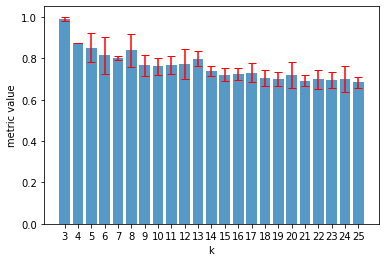

In [48]:
def plot_k_tracking_result(k_range, means, std_devs, x_label, y_label, filename):
    plt.bar(k_range, means, yerr=std_devs, align='center', alpha=0.75, ecolor='red', capsize=4)
    plt.xticks(k_range)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.savefig(filename)


def track_cluster_number(data, method, k_range, n_tries):
    metric_values = []
    for k in k_range:
        values = []
        for i in range(n_tries):
            km = KMeans(n_clusters=k, init=method)
            km.fit(data)
            value = metrics.davies_bouldin_score(data, km.labels_)
            values.append(value)
        metric_values.append(values)
    results = np.array(metric_values)
    return get_mean_and_stddev(results)

k_range = range(3, 26)
means, std_devs = track_cluster_number(prepared_data, full_random, k_range, 10)
plot_k_tracking_result(k_range, means, std_devs, "k", "metric value", "k_comparison")

Counter({3: 68, 8: 53, 9: 52, 0: 33, 6: 21, 2: 17, 7: 7, 4: 5, 5: 3, 1: 1})


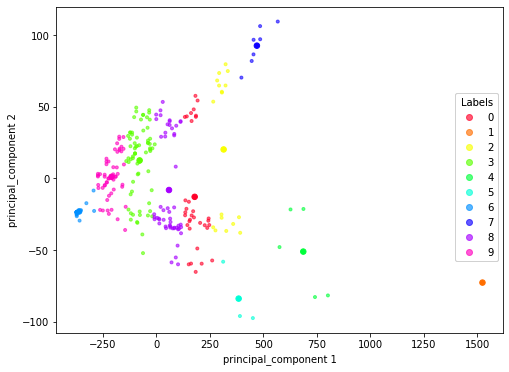

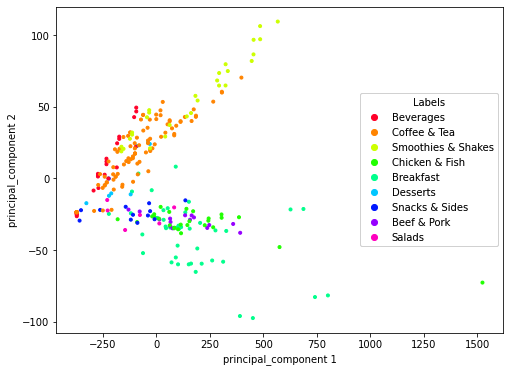

In [58]:
def calculate_pca(data, method, n_clusters):
    km = KMeans(n_clusters=n_clusters, init=method)
    km.fit(data)

    pca = PCA(n_components=2)
    pca.fit(prepared_data)
    processed_data = pca.transform(prepared_data)
    processed_centers = pca.transform(km.cluster_centers_)

    unique_labels = list(set(km.labels_))
    labels_indices = [unique_labels.index(label) for label in km.labels_]
    centres_indices = [i for i in unique_labels]

    print(collections.Counter(km.labels_))
    # for key, occurrences in collections.Counter(km.labels_).items():
    #     print(f"{key} -> {occurrences}")

    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6)
    sc = ax.scatter(processed_data[:,0], processed_data[:,1], c=labels_indices, cmap=plt.cm.gist_rainbow, s=9, alpha=0.6)
    ax.scatter(processed_centers[:,0], processed_centers[:,1], c=centres_indices, cmap=plt.cm.gist_rainbow, s=30)
    legend = ax.legend(sc.legend_elements(num=len(unique_labels) - 1)[0], unique_labels, loc="best", title="Labels", bbox_to_anchor=(1, 0.75), ncol=1)
    ax.add_artist(legend)
    ax.set_xlabel("principal_component 1")
    ax.set_ylabel("principal_component 2")
    plt.savefig("classification", bbox_inches='tight')
    plt.show()

    raw_data = pd.read_csv('menu.csv')
    categories = list(set(raw_data['Category']))

    categories_indices = [categories.index(category) for category in raw_data["Category"]]

    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6)
    sc = ax.scatter(processed_data[:,0], processed_data[:,1], c=categories_indices, cmap=plt.cm.gist_rainbow, s=9)
    legend = ax.legend(sc.legend_elements(num=len(categories) - 1)[0], categories, loc="best", title="Labels", bbox_to_anchor=(1, 0.75), ncol=1)
    ax.add_artist(legend)
    ax.set_xlabel("principal_component 1")
    ax.set_ylabel("principal_component 2")
    plt.savefig("classification_categories", bbox_inches='tight')
    plt.show()


calculate_pca(prepared_data, full_random, 10)